In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format
import gospapy

figures_path = Path('figures')
figures_path.mkdir(exist_ok=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def calculate_gospa(tracks, target, c=20, p=2, full_output=False):
    gospa, assignment, loc_err, miss_err, false_err = gospapy.calculate_gospa(
        tracks, target, c=c, p=p)
    if full_output:
        return gospa, assignment, loc_err, miss_err, false_err
    return gospa


traj_datapoint = {
    'angle': 203,
    'curve': 163,
    'line': 202,
    'trapezoid': 154
}

```python
np.save(out_path / "x_targets_log.npy", np.array(x_targets_log))
np.save(out_path / "prediction_error.npy", np.array(prediction_error))
filt.dump_log(out_path)

# -------
np.save(out_path / "x_log.npy", np.array(self.x_log))
np.save(out_path / "P_log.npy", np.array(self.P_log))
np.save(out_path / "z_log.npy", np.array(self.z_log))
np.save(out_path / "S_log.npy", np.array(self.S_log))
np.save(out_path / "updated_indicator_log.npy", np.array(self.updated_indicator_log))
np.save(out_path / "pruned_log.npy", np.array(self.pruned_log))
```

In [3]:
class Experiment(object):
    traj_datapoint = {
        'angle': 203,
        'curve': 163,
        'line': 202,
        'trapezoid': 154
    }

    def __init__(self, path: Path):
        self.path = path
        self.params = self.read_experiment_params()
        self.P_log = np.load(path / 'P_log.npy')
        self.x_targets = np.transpose(np.load(path / 'x_targets_log.npy'), axes=[0, 2, 1])
        self.x_estimates = np.load(path / 'x_log.npy')
        self.swapped = self.detect_swap()
        self.track_loss = self.detect_track_loss()
        self.error = np.load(path / 'prediction_error.npy')
        self.cumulative_error = np.sum(self.error)
        self.misdetections = np.load(path / 'misdetections.npy').item()
        self.cumulative_gospa = np.sum(
            [calculate_gospa(x_est, x_target) for x_est, x_target in zip(self.x_estimates, self.x_targets)]) #* (
                                           # 1 + self.misdetections / self.traj_datapoint[self.params['traj_type']])

    def detect_swap(self) -> int:
        """The first and last elements of the x_estimates array have similar x coordinates"""
        x_estimates = self.x_estimates
        return int(np.all(np.abs(x_estimates[0, :, 0] - x_estimates[-1, :, 0]) > 5))

    def detect_track_loss(self) -> int:
        """The number of misdetections is greater than 0"""
        x_estimates = self.x_estimates
        return int(np.any(np.abs(x_estimates[0, :, 0] - x_estimates[-1, :, 0]) > 10))

    def read_experiment_params(self) -> dict:
        dir_name: str = self.path.name
        params = dir_name.split('_')
        return {
            'type': self.path.parent.parent.name,
            'traj_type': self.path.parent.name,
            'mirror_offset': int(params[2]),
            'lambd': float(params[4]),
            'R': float(params[6])
        }

    def get_tuple(self) -> tuple:
        params = self.params
        experiment_type = params['type']
        traj_type = params['traj_type']
        offset = params['mirror_offset']
        lambd = params['lambd']
        R = params['R']

        return experiment_type, \
            traj_type, \
            offset, \
            lambd, \
            R, \
            self.cumulative_error, \
            self.cumulative_gospa, \
            self.swapped, \
            self.track_loss, \
            self.misdetections

# e = Experiment(Path('/Users/saladartem/Documents/FIT/Masters/Thesis/experiments/baseline/angle/mirror_offset_2_lambd_0.0005_R_2.0'))
# e.get_tuple()


## Baseline experiments

In [4]:
baseline_data = []
data_columns = ['type', 'traj_type', 'offset', 'lambd', 'R', 'RMSE', 'GOSPA', 'swapped', 'track_losses',
                'misdetections']
master_path = Path('experiment_results/param_grid/240427/baseline')

for exp in master_path.glob("*/mirror_offset_*"):
    if not exp.is_dir():
        continue
    e = Experiment(exp)
    baseline_data.append(e.get_tuple())

baseline_df = pd.DataFrame(baseline_data, columns=data_columns)

In [11]:
baseline_df.head()

type traj_type  offset  lambd     R    RMSE   GOSPA  swapped  \
0  baseline     angle       2   0.00 10.00 5518.30 5440.91        0   
1  baseline     angle       2   0.00 10.00 2388.51 3601.64        0   
2  baseline     angle       1   0.00 10.00 4529.19 4517.04        0   
3  baseline     angle       5   0.00  0.50  165.18  352.70        0   
4  baseline     angle      20   0.00  0.50  162.56  345.47        0   

   track_losses  misdetections  
0             1              0  
1             1              0  
2             1              0  
3             1              0  
4             1              0

## JPDA star

In [12]:
pruning_data = []
master_path = Path('experiment_results/param_grid/240427/pruning')

for exp in master_path.glob("*/mirror_offset_*"):
    if not exp.is_dir():
        continue
    e = Experiment(exp)
    pruning_data.append(e.get_tuple())

pruning_df = pd.DataFrame(pruning_data, columns=data_columns)

In [13]:
pruning_df.head()

type traj_type  offset  lambd     R    RMSE   GOSPA  swapped  \
0  pruning     angle       2   0.00 10.00 5518.36 5440.98        0   
1  pruning     angle       2   0.00 10.00 2361.35 3580.33        0   
2  pruning     angle       1   0.00 10.00 4529.74 4517.63        0   
3  pruning     angle       5   0.00  0.50  165.18  352.70        0   
4  pruning     angle      20   0.00  0.50  162.56  345.47        0   

   track_losses  misdetections  
0             1              0  
1             1              0  
2             1              0  
3             1              0  
4             1              0

## Mine

In [14]:
mine_data = []
master_path = Path('experiment_results/param_grid/240427/pruning_w_adaptive_gate')

for exp in master_path.glob("*/mirror_offset_*"):
    if not exp.is_dir():
        continue
    e = Experiment(exp)
    mine_data.append(e.get_tuple())

mine_df = pd.DataFrame(mine_data, columns=data_columns)

In [15]:
mine_df.head()

type traj_type  offset  lambd     R    RMSE   GOSPA  \
0  pruning_w_adaptive_gate     angle       2   0.00  1.00 3793.11 3047.21   
1  pruning_w_adaptive_gate     angle       5   0.00 10.00  615.33 1665.96   
2  pruning_w_adaptive_gate     angle       1   0.00  5.00 4383.95 2611.41   
3  pruning_w_adaptive_gate     angle       2   0.00  1.00  202.82  486.40   
4  pruning_w_adaptive_gate     angle      20   0.00  5.00  413.18 1104.37   

   swapped  track_losses  misdetections  
0        0             1              4  
1        0             1              0  
2        0             1              0  
3        0             1              0  
4        0             1              0

## Parameter tuning

In [16]:
df = pd.concat([baseline_df, pruning_df, mine_df])
df['type'] = df['type'].map({'baseline': 'JPDA', 'pruning': 'JPDA*', 'pruning_w_adaptive_gate': 'Ours'})

df.track_losses.unique()

array([1])

In [17]:
df_experiment_type = pd.get_dummies(df['type'], dtype=int)
df_traj_type = pd.get_dummies(df['traj_type'], dtype=int)
df = pd.concat([df_experiment_type, df_traj_type, df.loc[:, ~df.columns.isin(['type', 'traj_type'])]], axis=1)

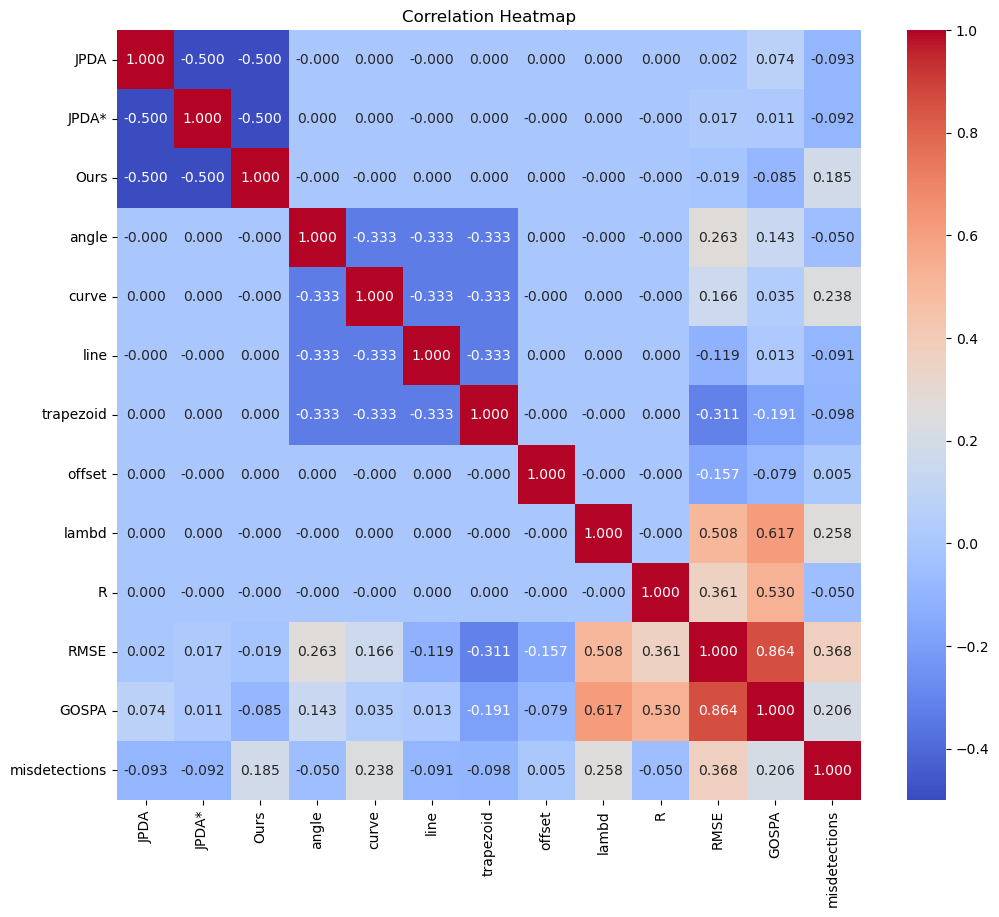

In [18]:
corr = df.drop(columns=['swapped', 'track_losses']).corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap')
# plt.show()
plt.savefig(figures_path / '05_09_correlation_heatmap_three_alg.svg', format='svg', dpi=300)

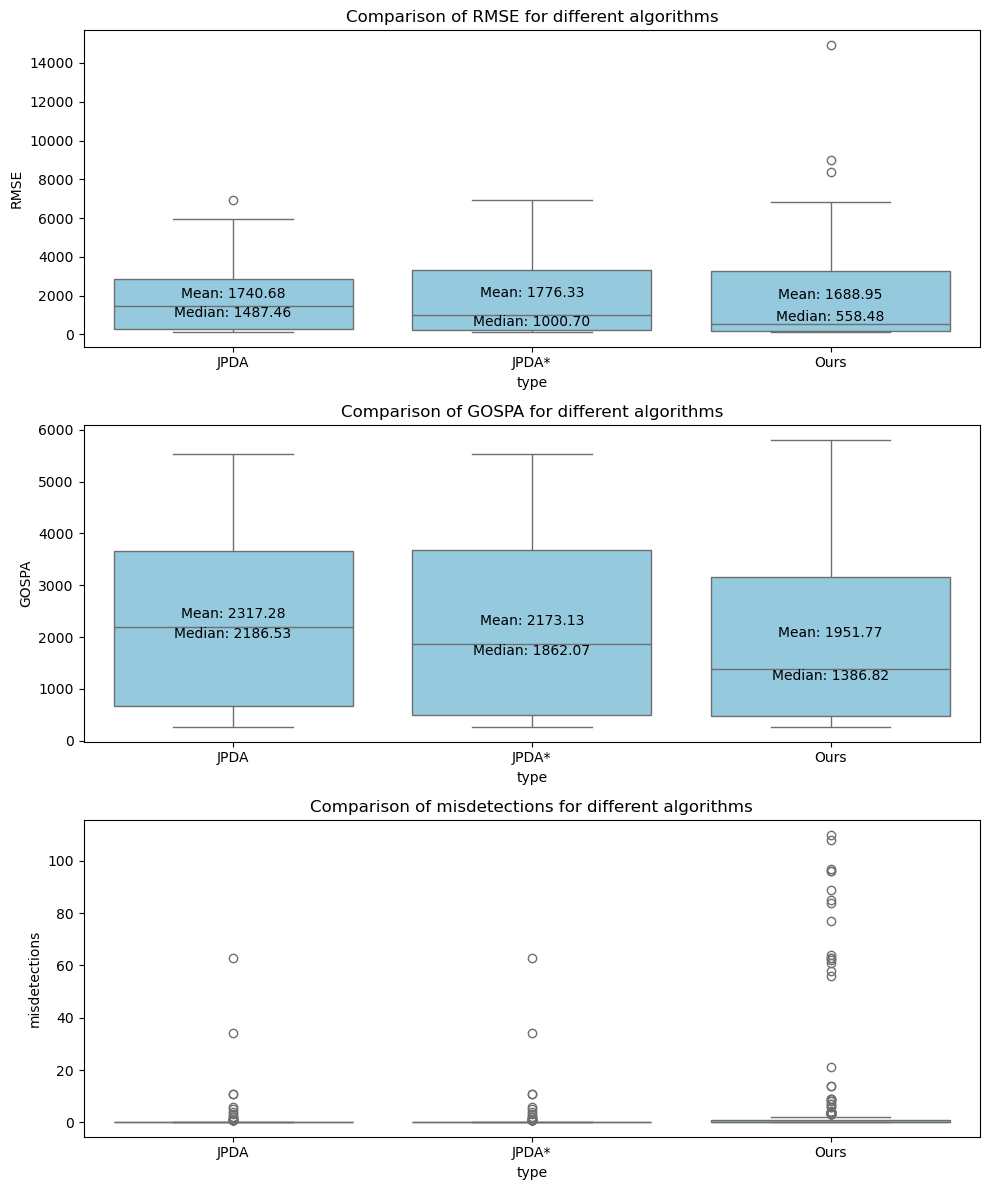

In [19]:
df = pd.concat([baseline_df, pruning_df, mine_df])
df['type'] = df['type'].map({'baseline': 'JPDA', 'pruning': 'JPDA*', 'pruning_w_adaptive_gate': 'Ours'})

# List of metrics you're interested in
metrics = ['RMSE', 'GOSPA', 'misdetections']

# Create a figure and a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Create a boxplot for each metric in a separate subplot
for i, metric in enumerate(metrics):
    ax = sns.boxplot(x='type', y=metric, data=df, ax=axs[i], color='skyblue')
    axs[i].set_title(f'Comparison of {metric} for different algorithms')

    # Calculate mean and median values for each type
    means = df.groupby('type')[metric].mean()
    medians = df.groupby('type')[metric].median()

    # Add mean and median values to the plot
    if metric != 'misdetections':
        for j, (mean, median) in enumerate(zip(means, medians)):
            if metric == 'RMSE' and j == 2:
                ax.text(j, median, f'Median: {median:.2f}', ha='center', va='bottom', color='black')
            else:
                ax.text(j, median, f'Median: {median:.2f}', ha='center', va='top',
                    color='black')
            ax.text(j, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', color='black')
# rename x_ticks for three axes


plt.tight_layout()
# plt.show()
plt.savefig(figures_path / '05_10_comparison_of_metrics.svg', format='svg', dpi=300)

In [20]:
means = df.groupby('type')['misdetections'].mean()
medians = df.groupby('type')['misdetections'].median()
# 75 percentille
q3 = df.groupby('type')['misdetections'].quantile(0.75)
# 95 percentille
q4 = df.groupby('type')['misdetections'].quantile(0.90)

In [21]:
means, medians, q3, q4

(type
 JPDA    0.52
 JPDA*   0.53
 Ours    4.81
 Name: misdetections, dtype: float64,
 type
 JPDA    0.00
 JPDA*   0.00
 Ours    0.00
 Name: misdetections, dtype: float64,
 type
 JPDA    0.00
 JPDA*   0.00
 Ours    1.00
 Name: misdetections, dtype: float64,
 type
 JPDA    1.00
 JPDA*   1.00
 Ours    4.00
 Name: misdetections, dtype: float64)

## Monte Carlo
### Param search Mine

In [22]:
mine_columns = ['model_type', 'curve_type', 'mirror_offset', 'R', 'lambd', 'squeeze_max_steps', 'P_squeeze', 'cooldown',
                'RMSE_mean', 'RMSE_std', 'GOSPA_mean', 'GOSPA_std', 'misdetections']
numeric_columns = ['mirror_offset', 'R', 'lambd', 'squeeze_max_steps', 'P_squeeze', 'cooldown', 'RMSE_mean', 'RMSE_std',
                   'GOSPA_mean', 'GOSPA_std', 'misdetections']

mine_MC = np.load(
    'experiment_results/experiments_MC/240427/240427_pruning_w_adaptive_gating_tuning_params_with_p_squeeze_misdetections_GOSPA_20_2.npy')
print(mine_MC.shape)

mine_MC_df = pd.DataFrame(mine_MC, columns=mine_columns)
# change the type of columns
mine_MC_df[numeric_columns] = mine_MC_df[numeric_columns].astype(float)
mine_MC_df.head()

(48, 13)


model_type curve_type  mirror_offset    R  lambd  \
0  pruning_w_adaptive_gate       line           2.00 5.00   0.00   
1  pruning_w_adaptive_gate       line           2.00 5.00   0.00   
2  pruning_w_adaptive_gate       line           2.00 5.00   0.00   
3  pruning_w_adaptive_gate       line           2.00 5.00   0.00   
4  pruning_w_adaptive_gate       line           2.00 5.00   0.00   

   squeeze_max_steps  P_squeeze  cooldown  RMSE_mean  RMSE_std  GOSPA_mean  \
0               1.00       0.95      0.00      12.14      8.13       17.89   
1               1.00       0.97      0.00      12.41      8.06       18.16   
2               1.00       0.99      0.00      12.96      8.00       18.75   
3               1.00       0.95      1.00      11.78      8.06       17.62   
4               1.00       0.97      1.00      12.40      8.06       18.20   

   GOSPA_std  misdetections  
0       6.43          13.00  
1       6.25           1.00  
2       5.85           0.00  
3       6.54           9.00  
4       6.22           2.00

In [23]:
# compute aggregate metric where Gospa is 2 times more important than RMSE and misdetections are added
mine_MC_df['aggregate_metric'] = mine_MC_df['GOSPA_mean'] * (1 + mine_MC_df['misdetections'] / 154)

# select the best combination of p_squeeze, squeeze_seq_limit and cooldown
optimal = mine_MC_df.loc[mine_MC_df.aggregate_metric == mine_MC_df.aggregate_metric.min()]
print(
    f"optimal P_squeeze: {optimal.P_squeeze.values[0]}\noptimal cooldown: {optimal.cooldown.values[0]}\nsqueeze_max_steps: {optimal.squeeze_max_steps.values[0]}")

optimal P_squeeze: 0.95
optimal cooldown: 3.0
squeeze_max_steps: 8.0


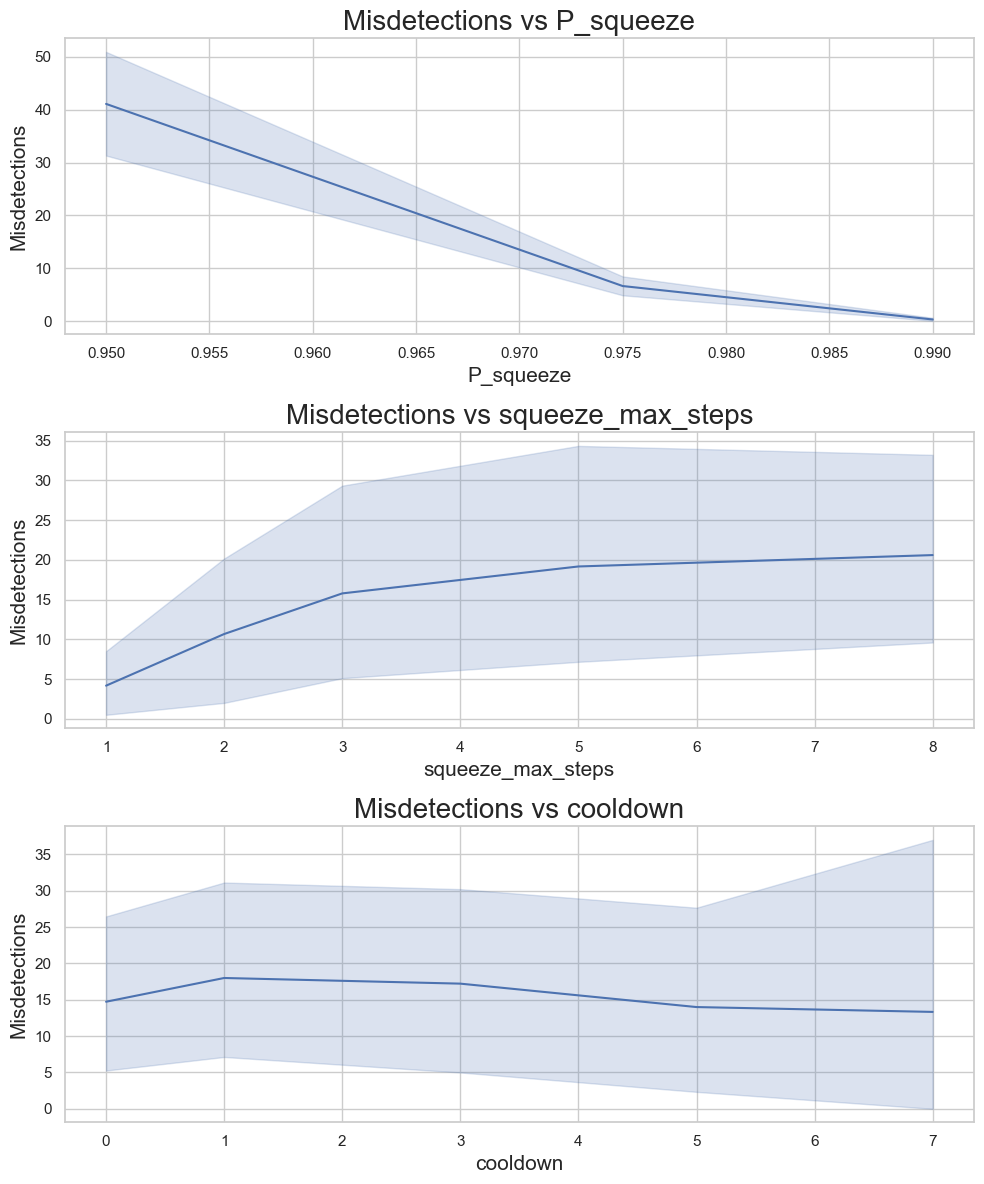

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the background color to white
sns.set(style="whitegrid")

# Create a figure and a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Create a line plot for misdetections vs P_Squeeze in the first subplot
sns.lineplot(x='P_squeeze', y='misdetections', data=mine_MC_df, ax=axs[0])
axs[0].set_title('Misdetections vs P_squeeze', fontsize=20)
axs[0].set_xlabel('P_squeeze', fontsize=15)
axs[0].set_ylabel('Misdetections', fontsize=15)

# Create a line plot for misdetections vs squeeze_seq_limit in the second subplot
sns.lineplot(x='squeeze_max_steps', y='misdetections', data=mine_MC_df, ax=axs[1])
axs[1].set_title('Misdetections vs squeeze_max_steps', fontsize=20)
axs[1].set_xlabel('squeeze_max_steps', fontsize=15)
axs[1].set_ylabel('Misdetections', fontsize=15)

# Create a line plot for misdetections vs cooldown in the third subplot
sns.lineplot(x='cooldown', y='misdetections', data=mine_MC_df, ax=axs[2])
axs[2].set_title('Misdetections vs cooldown', fontsize=20)
axs[2].set_xlabel('cooldown', fontsize=15)
axs[2].set_ylabel('Misdetections', fontsize=15)

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig(figures_path / '05_05_misdetections_vs_params.svg', format='svg', dpi=300)

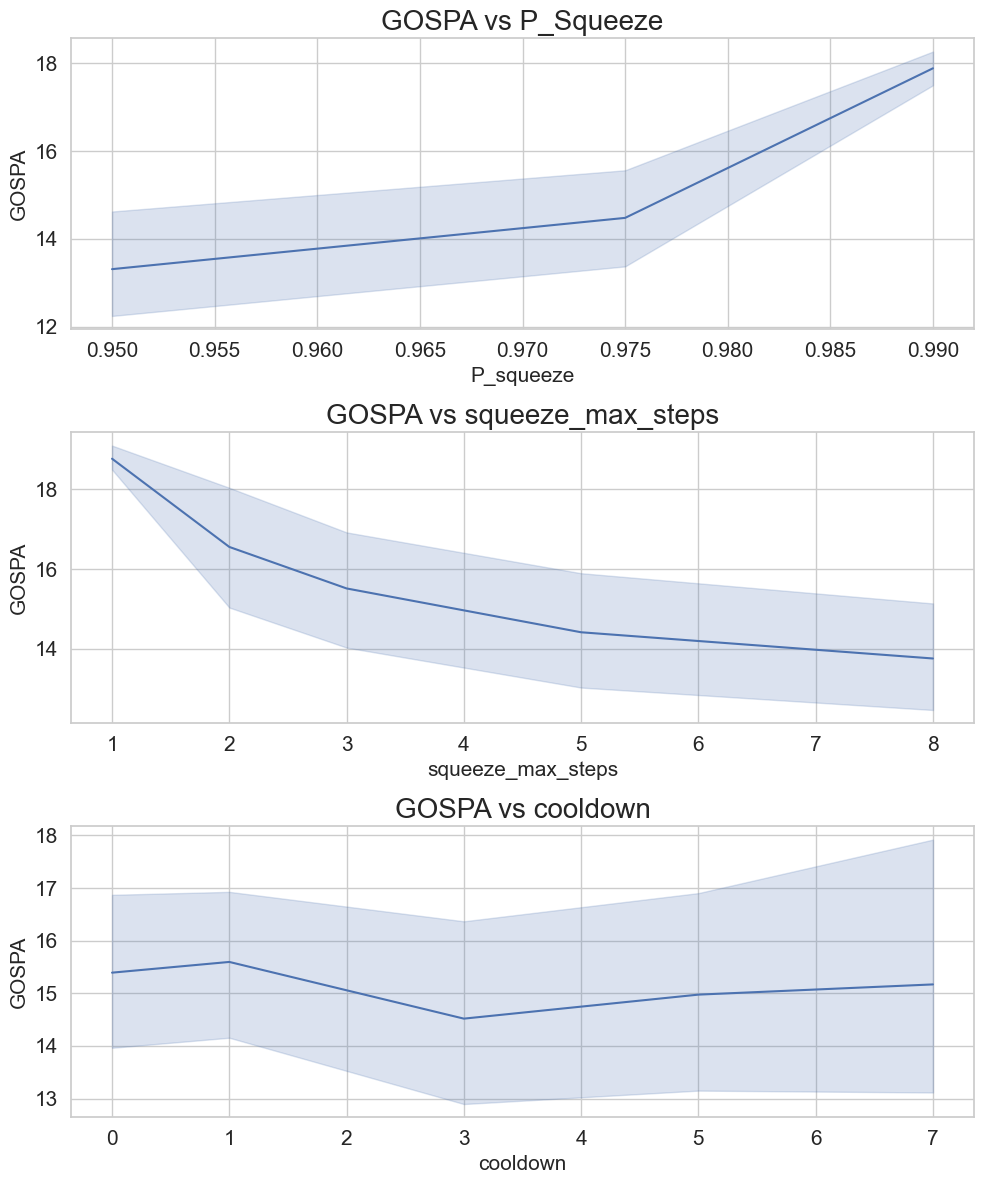

In [527]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(font_scale=3)  # crazy big
# Set the background color to white
sns.set(style="whitegrid")

# Create a figure and a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Create a line plot for aggregate_metric vs P_Squeeze in the first subplot
sns.lineplot(x='P_squeeze', y='aggregate_metric', data=mine_MC_df, ax=axs[0])
axs[0].set_title('GOSPA vs P_Squeeze', fontsize=20)
axs[0].set_xlabel('P_squeeze', fontsize=15)

# Create a line plot for aggregate_metric vs squeeze_seq_limit in the second subplot
sns.lineplot(x='squeeze_max_steps', y='aggregate_metric', data=mine_MC_df, ax=axs[1])
axs[1].set_title('GOSPA vs squeeze_max_steps', fontsize=20)
axs[1].set_xlabel('squeeze_max_steps', fontsize=15)

# Create a line plot for aggregate_metric vs cooldown in the third subplot
sns.lineplot(x='cooldown', y='aggregate_metric', data=mine_MC_df, ax=axs[2])
axs[2].set_title('GOSPA vs cooldown', fontsize=20)
axs[2].set_xlabel('cooldown', fontsize=15)

# Show the plot
for i in range(3):
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_ylabel('GOSPA', fontsize=15)
plt.tight_layout()
# plt.show()
plt.savefig(figures_path / '05_06_GOSPA_vs_params.svg', format='svg', dpi=300)


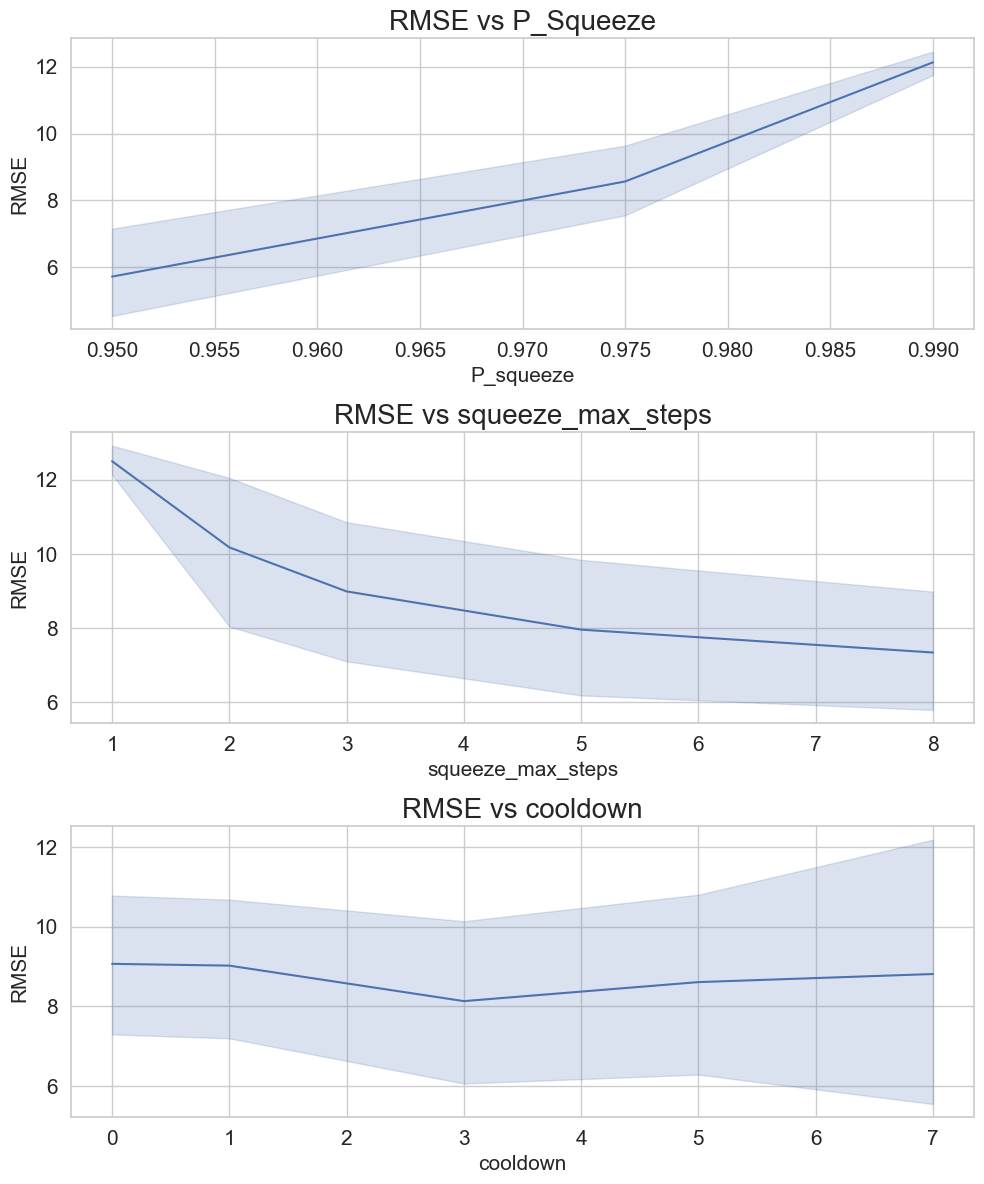

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the background color to white
sns.set(style="whitegrid")

# Create a figure and a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Create a line plot for RMSE vs P_Squeeze in the first subplot
sns.lineplot(x='P_squeeze', y='RMSE_mean', data=mine_MC_df, ax=axs[0])
axs[0].set_title('RMSE vs P_Squeeze', fontsize=20)
axs[0].set_xlabel('P_squeeze', fontsize=15)

# Create a line plot for RMSE vs squeeze_seq_limit in the second subplot
sns.lineplot(x='squeeze_max_steps', y='RMSE_mean', data=mine_MC_df, ax=axs[1])
axs[1].set_title('RMSE vs squeeze_max_steps', fontsize=20)
axs[1].set_xlabel('squeeze_max_steps', fontsize=15)

# Create a line plot for RMSE vs cooldown in the third subplot
sns.lineplot(x='cooldown', y='RMSE_mean', data=mine_MC_df, ax=axs[2])
axs[2].set_title('RMSE vs cooldown', fontsize=20)
axs[2].set_xlabel('cooldown', fontsize=15)

for i in range(3):
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_ylabel('RMSE', fontsize=15)

# Show the plot
plt.tight_layout()
plt.savefig(figures_path / '05_07_RMSE_vs_params.svg', format='svg', dpi=300)
# plt.show()

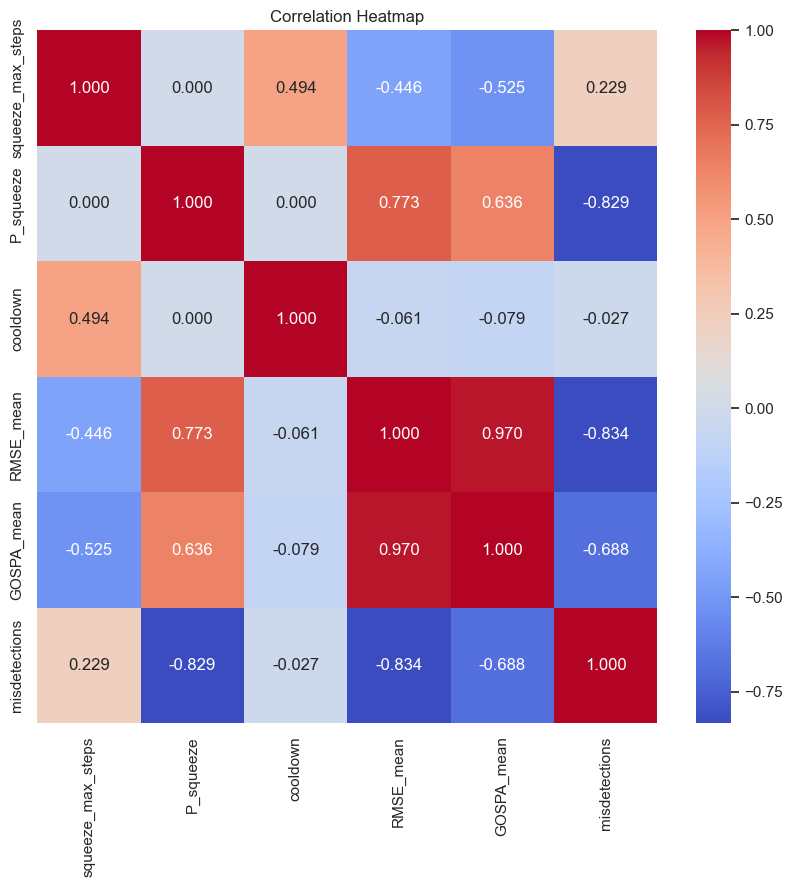

In [26]:
# heatmap with correlation between parameters
corr_plot_df = mine_MC_df.copy().drop(columns=['GOSPA_mean'])
corr_plot_df['GOSPA_mean'] = corr_plot_df['aggregate_metric']
corr = corr_plot_df[numeric_columns].drop(columns=['mirror_offset', 'R', 'lambd', 'RMSE_std', 'GOSPA_std']).corr()
plt.figure(figsize=(10, 9))
sns.heatmap(corr, robust=True, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap')
plt.savefig(figures_path / '05_08_correlation_heatmap.svg', format='svg', dpi=300)
plt.show()

|Optimal params for JPDAmine:
- optimal P_squeeze: 0.975
- optimal cooldown: 2.0
- squeeze_max_steps: 3.0

### Baseline + Pruning

In [27]:
baseline_MC = np.load('experiment_results/experiments_MC/240427/baseline_pruning_results.npy')
baseline_columns = ['model_type', 'curve_type', 'mirror_offset', 'R', 'lambd', 'RMSE_mean', 'RMSE_std', 'GOSPA_mean',
                    'GOSPA_std']

In [28]:
baseline_MC_df = pd.DataFrame(baseline_MC, columns=baseline_columns)
baseline_MC_df

model_type curve_type mirror_offset    R   lambd           RMSE_mean  \
0    pruning  trapezoid             2  5.0  0.0005   5.324659899150873   
1    pruning  trapezoid             2  5.0   0.001  7.8272908502541965   
2    pruning  trapezoid             2  5.0   0.003  10.705653543098446   
3    pruning  trapezoid             2  5.0   0.005  11.811507604800346   
4   baseline  trapezoid             2  5.0  0.0005   4.818863099630568   
5   baseline  trapezoid             2  5.0   0.001   7.674719963363739   
6   baseline  trapezoid             2  5.0   0.003  10.426707461321522   
7   baseline  trapezoid             2  5.0   0.005  11.643828785195971   

             RMSE_std          GOSPA_mean           GOSPA_std  
0   7.070509326392079   9.298093006933584  1.6369527279396519  
1    6.00491317290447   10.28582587772521   1.305116232146485  
2   5.697607686308993   10.46202912041904   1.201723642949977  
3    6.11667539411949  10.391532600981941  1.2232036035111642  
4   4.772542554247689    9.71675700970617  1.4139305235722435  
5   5.865634863803627  10.081287329607976   1.268122396855396  
6   5.577690350966412  10.525486888728338  1.0436976352101792  
7  6.0271304963205905  10.403821464770445  1.1716486225245164

## Mine

In [29]:
mine_columns = ['model_type', 'curve_type', 'mirror_offset', 'R', 'lambd', 'squeeze_seq_limit', 'P_squeeze', 'cooldown',
                'RMSE_mean', 'RMSE_std', 'GOSPA_mean', 'GOSPA_std']
mine_MC = np.load('experiment_results/experiments_MC/240427/pruning_w_adaptive_gating_tuning_params_with_p_squeeze.npy')
print(mine_MC.shape)
mine_MC_df = pd.DataFrame(mine_MC, columns=mine_columns)
mine_MC_df.head()

(30, 12)


model_type curve_type mirror_offset    R   lambd  \
0  pruning_w_adaptive_gate  trapezoid             2  5.0  0.0015   
1  pruning_w_adaptive_gate  trapezoid             2  5.0  0.0015   
2  pruning_w_adaptive_gate  trapezoid             2  5.0  0.0015   
3  pruning_w_adaptive_gate  trapezoid             2  5.0  0.0015   
4  pruning_w_adaptive_gate  trapezoid             2  5.0  0.0015   

  squeeze_seq_limit P_squeeze cooldown          RMSE_mean           RMSE_std  \
0                 2      0.95        2  7.888014910376087  6.232315093225619   
1                 2     0.975        2  8.646663817495549  5.846518787316713   
2                 2      0.99        2  9.133843164781794  5.681418703524981   
3                 3      0.95        2  7.196808470677919  6.351283979389157   
4                 3     0.975        2   8.43766066468967  6.071347453600178   

           GOSPA_mean           GOSPA_std  
0   9.851006955569732  1.7114571061561379  
1   9.986661162336212  1.6560792932602066  
2  10.091810921168463   1.595624818775553  
3   9.694907301472849   1.748804978256599  
4   9.945123002746795  1.6683335802082717

In [30]:
optimal = mine_MC_df.loc[mine_MC_df.RMSE_mean == mine_MC_df.RMSE_mean.min()]

print(
    f"optimal P_squeeze: {optimal.squeeze_seq_limit.values[0]}\n  optimal cooldown: {optimal.cooldown.values[0]}, squeeze P: {optimal.P_squeeze.values[0]}")

optimal P_squeeze: 8
  optimal cooldown: 3, squeeze P: 0.95
